In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [68]:
import numpy as np
import json
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit.quantum_info import Statevector
from qiskit.compiler import transpile  # Import transpile from qiskit.compiler
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session, Options, SamplerV2
from qiskit.primitives import BackendSamplerV2  # Import BackendSamplerV2
from qiskit.providers import Options  # Import Options
import gmpy2
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, EstimatorOptions
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
import numpy as np
import pickle
from collections import Counter

In [3]:
from sentence_transformers import SentenceTransformer
import torch

In [4]:
matryoshka_dim = 128
model = SentenceTransformer("google/embeddinggemma-300m", truncate_dim=matryoshka_dim)

In [5]:
text1 = ["the quick brown fox jumps over the lazy dog"]
text2 = ["the brown dog jumps over the lazy cat"]
text3 = ["the quick fox runs fast"]
text4 = ["the dog runs quickly"]

In [6]:
text1_embedding = model.encode(text1)[0]
text2_embedding = model.encode(text2)[0]
text3_embedding = model.encode(text3)[0]
text4_embedding = model.encode(text4)[0]

In [33]:
print(type(text1_embedding))

<class 'numpy.ndarray'>


In [41]:
print(f"Shape: {text1_embedding.shape}")
print(text1_embedding[0:10])
print(text2_embedding[0:10])

Shape: (30,)
[-0.28229456 -0.81841963  0.98502959 -0.46779361  0.48812098  0.82106004
  0.30049165  0.46583087 -0.0029183   0.3119031 ]
[ 0.74514798 -0.16268356  0.41530528 -0.54014173 -0.73279148  0.56922121
  0.78390637 -0.18820284  0.16311357 -0.61485606]


In [7]:
# Convert the NumPy array to a list of gmpy2 floats
# Explicitly convert NumPy float64 to Python float
text1_embedding_gmpy2 = [gmpy2.mpfr(float(x)) for x in text1_embedding]
text2_embedding_gmpy2 = [gmpy2.mpfr(float(x)) for x in text2_embedding]
text3_embedding_gmpy2 = [gmpy2.mpfr(float(x)) for x in text3_embedding]
text4_embedding_gmpy2 = [gmpy2.mpfr(float(x)) for x in text4_embedding]

In [8]:
print(text1_embedding_gmpy2[0:10])
print(text2_embedding_gmpy2[0:10])

[mpfr('-0.12617930769920349'), mpfr('0.048215638846158981'), mpfr('0.072247982025146484'), mpfr('-0.021703166887164116'), mpfr('-0.085041776299476624'), mpfr('0.0050733117386698723'), mpfr('0.033469811081886292'), mpfr('0.060756959021091461'), mpfr('0.042932808399200439'), mpfr('-0.026666676625609398')]
[mpfr('-0.12587355077266693'), mpfr('0.052004154771566391'), mpfr('0.060552578419446945'), mpfr('-0.0072669140063226223'), mpfr('-0.079314962029457092'), mpfr('0.019567230716347694'), mpfr('0.038008805364370346'), mpfr('0.040015958249568939'), mpfr('0.010915853083133698'), mpfr('-0.042791485786437988')]


In [9]:
# Calculate the norm using gmpy2
norm1 = gmpy2.sqrt(sum(x * x for x in text1_embedding_gmpy2))
norm2 = gmpy2.sqrt(sum(x * x for x in text2_embedding_gmpy2))
norm3 = gmpy2.sqrt(sum(x * x for x in text3_embedding_gmpy2))
norm4 = gmpy2.sqrt(sum(x * x for x in text4_embedding_gmpy2))

In [10]:
# Normalize
normalized_text1_embedding_gmpy2 = [x / norm1 for x in text1_embedding_gmpy2]
normalized_text2_embedding_gmpy2 = [x / norm2 for x in text2_embedding_gmpy2]
normalized_text3_embedding_gmpy2 = [x / norm3 for x in text3_embedding_gmpy2]
normalized_text4_embedding_gmpy2 = [x / norm4 for x in text4_embedding_gmpy2]

In [11]:
print(normalized_text1_embedding_gmpy2[0:10])
print(normalized_text2_embedding_gmpy2[0:10])

[mpfr('-0.24961653505786527'), mpfr('0.095383473913731004'), mpfr('0.1429258986032132'), mpfr('-0.042934688872054254'), mpfr('-0.16823545731956369'), mpfr('0.01003637221163135'), mpfr('0.066212269060932055'), mpfr('0.12019357110162125'), mpfr('0.084932617465765969'), mpfr('-0.052753843258209629')]
[mpfr('-0.24447903416495445'), mpfr('0.10100553653308197'), mpfr('0.11760878911663039'), mpfr('-0.014114228975983727'), mpfr('-0.15405019714437396'), mpfr('0.038004629546482115'), mpfr('0.073822943487368509'), mpfr('0.077721354200203582'), mpfr('0.021201413660530233'), mpfr('-0.083112147479226003')]


In [12]:
# Calculate the new norm
new_norm1 = gmpy2.sqrt(sum(x * x for x in normalized_text1_embedding_gmpy2))
new_norm2 = gmpy2.sqrt(sum(x * x for x in normalized_text2_embedding_gmpy2))
new_norm3 = gmpy2.sqrt(sum(x * x for x in normalized_text3_embedding_gmpy2))
new_norm4 = gmpy2.sqrt(sum(x * x for x in normalized_text4_embedding_gmpy2))

In [13]:
print(f"gmpy2 norm: {new_norm1}")
print(f"gmpy2 norm: {new_norm2}")
print(f"gmpy2 norm: {new_norm3}")
print(f"gmpy2 norm: {new_norm4}")

gmpy2 norm: 1.000000
gmpy2 norm: 1.000000
gmpy2 norm: 1.000000
gmpy2 norm: 1.000000


In [14]:
# Convert back to NumPy array of float64 (if needed)
normalized_text1_embedding_np = np.array([float(x) for x in normalized_text1_embedding_gmpy2], dtype=np.float64)
normalized_text2_embedding_np = np.array([float(x) for x in normalized_text2_embedding_gmpy2], dtype=np.float64)
normalized_text3_embedding_np = np.array([float(x) for x in normalized_text3_embedding_gmpy2], dtype=np.float64)
normalized_text4_embedding_np = np.array([float(x) for x in normalized_text4_embedding_gmpy2], dtype=np.float64)

In [15]:
normalized_text1_embedding = normalized_text1_embedding_np.tolist()
normalized_text2_embedding = normalized_text2_embedding_np.tolist()
normalized_text3_embedding = normalized_text3_embedding_np.tolist()
normalized_text4_embedding = normalized_text4_embedding_np.tolist()

In [16]:
print(type(normalized_text1_embedding))

<class 'list'>


In [17]:
new_norm1 = np.linalg.norm(normalized_text1_embedding)
new_norm2 = np.linalg.norm(normalized_text2_embedding)
new_norm3 = np.linalg.norm(normalized_text3_embedding)
new_norm4 = np.linalg.norm(normalized_text4_embedding)

In [18]:
print(new_norm1)
print(new_norm2)
print(new_norm3)
print(new_norm4)

1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0


In [19]:
vectora = normalized_text1_embedding
vectorb = normalized_text2_embedding

In [20]:
print(vectora[0:10])
print(vectorb[0:10])

[-0.24961653505786527, 0.095383473913731, 0.1429258986032132, -0.042934688872054254, -0.16823545731956369, 0.01003637221163135, 0.06621226906093206, 0.12019357110162125, 0.08493261746576597, -0.05275384325820963]
[-0.24447903416495445, 0.10100553653308197, 0.11760878911663039, -0.014114228975983727, -0.15405019714437396, 0.038004629546482115, 0.07382294348736851, 0.07772135420020358, 0.021201413660530233, -0.083112147479226]


In [21]:
print(np.linalg.norm(vectora))
print(np.linalg.norm(vectorb))

1.0000000000000002
1.0000000000000002


In [22]:
def calculate_complex_similarity_exact(vectora, vectorb):
    """
    Calculates the complex cosine similarity between two vectors.
    """

    if len(vectora) != len(vectorb):
        raise ValueError("Vectors must have the same dimension")

    # Calculate the dot product of the vectors and their complex conjugates
    numerator = np.sum(np.conjugate(vectora) * vectorb)  

    # Calculate the magnitudes of the vectors
    magnitude_a = np.linalg.norm(vectora)
    magnitude_b = np.linalg.norm(vectorb)

    # Calculate the cosine similarity
    if magnitude_a == 0 or magnitude_b == 0:
        return 0.0 
    else:
        similarity = numerator / (magnitude_a * magnitude_b)
        return similarity

In [23]:
complex_similarity_exact = calculate_complex_similarity_exact(vectora,vectorb)
print("Complex similarity exact: ",complex_similarity_exact)

Complex similarity exact:  0.8681570186338715


In [24]:
def create_converted_vectors(vectora, vectorb):
    """
    Creates new vectors vectora_q and vectorb_q based on the conversion formulas.
    """

    if len(vectora) != len(vectorb):
        raise ValueError("Vectors must have the same length.")

    vectora_q = []
    vectorb_q = []

    for i in range(len(vectora)):
        a = vectora[i]
        b = vectorb[i]
        denominator = np.sqrt(abs(a)**2 + abs(b)**2)

        if denominator == 0:
            aq_i = 0 
            bq_i = 0  
        else:
            aq_i = a / denominator
            bq_i = b / denominator

        vectora_q.append(aq_i)
        vectorb_q.append(bq_i)

    return vectora_q, vectorb_q

In [25]:
vectora_q, vectorb_q = create_converted_vectors(vectora,vectorb)

In [26]:
def calculate_qubit_states_theoretical(vectora, vectorb):
    """
    Calculates qubit states based on the provided formulas and prints the results.
    Creates 2 qubits for each element in the input vectors.
    """

    if len(vectora) != len(vectorb):
        raise ValueError("Vectors must have the same length.")

    results = {}
    n = len(vectora)
    for i in range(n):
        a = vectora[i]
        b = vectorb[i]

        # Qubit 2*i (cos)
        qubit_key_cos = f"qubit {i}"
        results[qubit_key_cos] = []

        cos_results = {}
        cos_results["identifier"] = "cos"
        cos_results["state 0"] = abs((a + b) / np.sqrt(2))**2
        cos_results["state 1"] = abs((a - b) / np.sqrt(2))**2
        results[qubit_key_cos].append(cos_results)

    return json.dumps(results, indent=4)  # Convert to JSON string with indentation


In [27]:
theoretical_results = calculate_qubit_states_theoretical(vectora_q,vectorb_q)
print("Theoretical results: ",theoretical_results)

Theoretical results:  {
    "qubit 0": [
        {
            "identifier": "cos",
            "state 0": 0.9998918976957657,
            "state 1": 0.00010810230423409769
        }
    ],
    "qubit 1": [
        {
            "identifier": "cos",
            "state 0": 0.9991811558923341,
            "state 1": 0.000818844107665796
        }
    ],
    "qubit 2": [
        {
            "identifier": "cos",
            "state 0": 0.9906456104460373,
            "state 1": 0.009354389553962759
        }
    ],
    "qubit 3": [
        {
            "identifier": "cos",
            "state 0": 0.7966759697859768,
            "state 1": 0.20332403021402307
        }
    ],
    "qubit 4": [
        {
            "identifier": "cos",
            "state 0": 0.9980664646102999,
            "state 1": 0.0019335353896998075
        }
    ],
    "qubit 5": [
        {
            "identifier": "cos",
            "state 0": 0.7468664738051111,
            "state 1": 0.253133526194889
        }


In [30]:
def calculate_complex_similarity_exact(vectora, vectorb):
    """
    Calculates the complex cosine similarity between two vectors.
    """

    if len(vectora) != len(vectorb):
        raise ValueError("Vectors must have the same dimension")

    # Calculate the dot product of the vectors and their complex conjugates
    numerator = np.sum(np.conjugate(vectora) * vectorb)  # Corrected order

    # Calculate the magnitudes of the vectors
    magnitude_a = np.linalg.norm(vectora)
    magnitude_b = np.linalg.norm(vectorb)

    # Calculate the cosine similarity
    if magnitude_a == 0 or magnitude_b == 0:
        return 0.0  # Handle the case where one or both vectors are zero vectors
    else:
        similarity = numerator / (magnitude_a * magnitude_b)
        return similarity

In [85]:
def calculate_complex_cosine_similarity(vectora, vectorb, simulation_result_json):
    """
    Calculates the final complex result based on the input vectors and the
    simulation result (JSON string).
    """

    if len(vectora) != len(vectorb):
        raise ValueError("Vectors must have the same length.")

    simulation_result = json.loads(simulation_result_json)  # Parse JSON string to dictionary
    N = len(vectora)  # Total number of qubits (simulation results)
    if len(simulation_result) != N:
        raise ValueError("Simulation result length does not match expected number of qubits.")

    sum_real = 0.0
    sum_img = 0.0

    for i in range(len(vectora)):  # Iterate from i=0 to N/2 -1
        a = vectora[i]
        b = vectorb[i]
        c2_2i = abs(a)**2 + abs(b)**2

        # Extract probabilities from simulation result
        prob_2i = simulation_result.get(f"q{i}_0")

        if prob_2i is None is None:
            raise ValueError(f"Missing probability for qubit {i} in simulation result.")

        sum_real += c2_2i * (2 * prob_2i - 1) / 2

    return sum_real 

In [83]:
complex_similarity_exact = calculate_complex_similarity_exact(vectora, vectorb)
print("Complex similarity exact: ",complex_similarity_exact)

Complex similarity exact:  0.8681570186338715


In [88]:
complex_cosine_similarity = calculate_complex_cosine_similarity(vectora, vectorb, quantum_computer_results)
print("Complex cosine similarity experimental: ",complex_cosine_similarity)

Complex cosine similarity experimental:  0.8634709978300978


In [37]:
from qiskit import *

In [63]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
token="API key", # Use the 44-character API_KEY you created and saved from the IBM Quantum Platform Home dashboard
instance="result_instance",
    overwrite=True)

In [64]:
def run_and_store_results(vectora_q, vectorb_q, filename='quantum_results.pkl'):
    if len(vectora_q) != len(vectorb_q):
        raise ValueError("Vectors must have the same length.")

    num_qubits = len(vectora_q)
    qc = QuantumCircuit(num_qubits, num_qubits)

    for i in range(len(vectora_q)):
        a = vectora_q[i]
        b = vectorb_q[i]

        initial_state_0 = np.array([a, b], dtype=np.complex128)
        norm_0 = np.linalg.norm(initial_state_0)
        normalized_state_0 = initial_state_0 / norm_0

        qc.initialize(normalized_state_0, i)

    qc.h(range(num_qubits))
    qc.measure(range(num_qubits), range(num_qubits))

    try:
        # Connect to IBM Quantum
        service = QiskitRuntimeService()

        # Select a real quantum backend
        backend = service.least_busy(simulator=False, operational=True, min_num_qubits=num_qubits)
        print(f"Using backend: {backend.name}")

        # Transpile the circuit for the backend
        transpiled_qc = transpile(qc, backend)

        # Create a session
        with Session(backend=backend) as session:
            # Create a Sampler instance
            sampler = Sampler()

            # Run the circuit using Sampler within the session
            job = sampler.run([transpiled_qc], shots=4096)
            print(f"Job ID: {job.job_id()}")
            result = job.result()

            # Store the result using pickle
            with open(filename, 'wb') as f:
                pickle.dump(result, f)

            print(f"Results stored in {filename}")

    except Exception as e:
        print(f"Error running the circuit: {e}")
        print(f"Error type: {type(e)}")
        print(f"Error message: {e}")


In [65]:
run_and_store_results(vectora_q, vectorb_q)

Using backend: ibm_fez
Job ID: d4jfs4l74pkc738603vg
Results stored in quantum_results.pkl


In [81]:
def load_and_analyze_results(filename='quantum_results.pkl'):
    # Load the results from the file
    with open(filename, 'rb') as f:
        result = pickle.load(f)

    # Access the first PubResult from the PrimitiveResult
    pub_result = result[0]

    # Extract the data from the PubResult
    data_bin = pub_result.data

    # Access the BitArray under the key 'c'
    bit_array = data_bin['c']

    # Use get_bitstrings to extract the bitstrings
    bitstrings = bit_array.get_bitstrings()

    # Count the occurrences of each bitstring
    counts = Counter(bitstrings)

    # Calculate the probabilities based on the bitstring values
    total_shots = sum(counts.values())
    probabilities = {}
    for bitstring, count in counts.items():
        prob = count / total_shots
        for i in range(len(bitstring)):
            if bitstring[len(bitstring) - 1 - i] == '0':
                probabilities[f"q{i}_0"] = probabilities.get(f"q{i}_0", 0) + prob

    # Print the calculated probabilities
   # print("Calculated probabilities:", probabilities)

    # Create the JSON output
    json_output = json.dumps(probabilities, indent=4)

    # Assuming normalized_states is needed, but since it's not stored, we'll return an empty list
    normalized_states = []

    return json_output, normalized_states



In [87]:
quantum_computer_results, _ = load_and_analyze_results()
print("Quantum computer results: ",quantum_computer_results)

Quantum computer results:  {
    "q0_0": 0.999267578125,
    "q1_0": 0.998779296875,
    "q2_0": 0.98486328125,
    "q3_0": 0.796142578125,
    "q4_0": 0.99853515625,
    "q5_0": 0.755859375,
    "q6_0": 0.9951171875,
    "q7_0": 0.9521484375,
    "q8_0": 0.74072265625,
    "q9_0": 0.94921875,
    "q10_0": 0.83740234375,
    "q11_0": 0.9755859375,
    "q12_0": 0.7734375,
    "q14_0": 0.958984375,
    "q15_0": 0.880615234375,
    "q17_0": 0.963623046875,
    "q18_0": 0.969970703125,
    "q20_0": 0.865966796875,
    "q21_0": 0.93701171875,
    "q24_0": 0.9990234375,
    "q26_0": 0.906005859375,
    "q28_0": 0.924560546875,
    "q29_0": 0.787109375,
    "q30_0": 0.998291015625,
    "q33_0": 0.58447265625,
    "q34_0": 0.99609375,
    "q35_0": 0.972412109375,
    "q37_0": 0.99853515625,
    "q38_0": 0.77099609375,
    "q39_0": 0.883056640625,
    "q43_0": 0.996337890625,
    "q44_0": 0.976806640625,
    "q46_0": 0.777099609375,
    "q47_0": 0.99365234375,
    "q48_0": 0.97998046875,
    "q

In [38]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()  # Loads the saved account and default instance
#print(f"Using instance: {service.active_instance()}")

In [39]:
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=128)
backend.name

'ibm_fez'

In [58]:
import qiskit_ibm_runtime
print(qiskit_ibm_runtime.__version__)

0.43.1


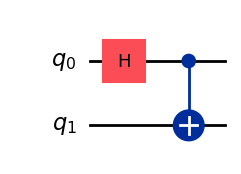

In [4]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl").
# These guides are written by using Jupyter notebooks, which
# display the output of the last line of each cell.
# If you're running this in a script, use `print(qc.draw())` to
# print a text drawing.
qc.draw("mpl")